### Import some useful pkgs

In [80]:
import os
import sys
import time
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Reload my modules

In [81]:
import importlib
import sgm_fns
import utils
importlib.reload(sgm_fns)
importlib.reload(utils);

In [82]:
from spectrome import Brain, path, functions
from sgm_fns import meg_psd2spatialfeature, Sgm
from utils import mag2db

In [83]:
from spectrome import Brain, path, functions
from tqdm import trange, tqdm

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sklearn.preprocessing import minmax_scale

import numpy as np
import xarray as xr
from easydict import EasyDict as edict
from pathlib import Path
import pickle
import scipy

In [84]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json

### Some functions

In [85]:
std_psd = lambda x: (x- x.mean(axis=1).reshape(-1, 1))/x.std(axis=1).reshape(-1, 1)
std_vec = lambda x: (x-x.mean())/x.std()
minmax_vec = lambda x: (x-x.min())/(x.max()-x.min())

### Load real data PSD and brain

#### PSD and connectome

In [86]:
# Load data
ind_psd_xr = xr.open_dataarray('../data/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
freqs = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray('../data/individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values



data_dir = path.get_data_path()

#### data for brain plots

In [87]:
# Get reorder indeix
# dk86.***.txt is the order for the MEG data
# DK68_labelorder.xlsx is the order for the template
dk_brainnet = pd.read_excel(Path(data_dir)/"DK68_labelorder.xlsx")
with open(Path(data_dir)/'dk86atlas_regions_python.txt') as f:
    dk_python = f.readlines()
    
brainnet_order = dk_brainnet["Order in Brainstorm"]
dk_python_renamed = []
brainnet_renamed = []

for i in range(len(dk_python)):
    sp1 = dk_python[i].split('=')
    sp2 = sp1[1].split('_')
    dk_python_renamed.append((sp2[0] + ' ' + sp2[1]).lower().strip())

for i in range(len(brainnet_order)):
    brainnet_renamed.append((brainnet_order[i].replace("'","")).lower())

d = {x: a for a, x in enumerate(dk_python_renamed[0:68])}
orderedind = np.array([d[x] for x in brainnet_renamed])

In [88]:
def reorderU(wU):
    wUreorder = wU.copy()
    wUreorder = wU[orderedind]
    return wUreorder

with open(Path(data_dir)/'BNVtemplate_DK68.txt', "r") as tf:
    DKtmplateRaw = tf.readlines()
DKtmplate = np.array([int(x.strip()) for x in DKtmplateRaw])

def U2BrainVec(wU):
    emVec = np.zeros_like(DKtmplate, dtype=np.float64)
    for idx in range(1, 69):
        emVec[DKtmplate==idx] = wU[idx-1]
    return emVec

### Set up Parameters

In [89]:
metd = edict()
metd.SBI = "SBI-SGM"
metd.anl = "Ann-SGM"

plot_sets = edict()
plot_sets.col = ["dodgerblue", "coral"]
plot_sets.alpha = 0.8
plot_sets.marker = ["o", "h"]

In [90]:
paras = edict()
paras.noise_sd = 0.2
paras.num_prior_sps = int(1e5)
paras.path = Path("./main_results_nsf")

paras.robustParas = edict()
paras.robustParas.num_rep = 100
paras.robustParas.noise_sd = 0.2
paras.robustParas.num_prior_sps = int(1e5)
paras.robustParas.path = Path(paras.path/"robust_results")

paras.tuningParas = edict()
paras.tuningParas.noise_sd = 0.2
paras.tuningParas.num_prior_sps = int(1e5)
paras.tuningParas.path = Path(paras.path/"tuning_results")

paras.fig_dir = Path("./figs")
paras.res_dir = Path("./results")
paras.name_order = ['taue','taui','tauG','speed','alpha','gii','gei']
paras.name_order_latex = [r'$\tau_e$',r'$\tau_i$',r'$\tau_G$',r'$v$',r'$\alpha$',r'$g_{ii}$',r'$g_{ei}$']

In [91]:
#v_lower = 3.5-1.8
#v_upper = 3.5+1.8
#bnds = ((5.0,30.0), (5.0,200.0), (0.1,1.0), (v_lower,v_upper), (0.5,10.0), (0.5,10.0), (5.0,30.0))
#This is the order for the above bounds:  tau_e, tau_i, alpha, speed, gei, gii, tauC,

# taue, taui, tauC, speed, alpha, gii, gei
par_low = np.asarray([0.005,0.005,0.005,1.7,0.1,0.5,0.5])
par_high = np.asarray([0.03, 0.20, 0.03,5.3,  1, 10, 10])
plotLimits = np.array([par_low, par_high]).T

In [92]:
# obtain the brain
data_dir = path.get_data_path()
brain = Brain.Brain()
brain.add_connectome(data_dir)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

sgmmodel = Sgm(brain.reducedConnectome, brain.distance_matrix, freqs)

### Tuning parameters-the prior sample sizes

#### the results saved

In [93]:
fils = list(paras.tuningParas.path.glob("tuningParasSps_200000_sd20_*.pkl"))
tmp_sort = lambda p: int(p.stem.split("_")[-1])
sorted_fils = sorted(fils, key=tmp_sort)
paras.tuningParas.num_prior_spss = [200000, 100000, 50000, 25000, 12500, 6250, 3125, 1600, 800]

#### Get the posterior samples 
Saved

In [71]:
for ixfil in tqdm(sorted_fils[:]):
    with open(ixfil, "rb") as f:
        curRes = pickle.load(f)
        
    if tmp_sort(ixfil) not in [4, 5, 10]:
        continue
    postSpss = []
    for iy in range(ind_psd.shape[-1]):
        curC = ind_conn[:, :, iy]
        curBrain = Brain.Brain()
        curBrain.add_connectome(data_dir) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
        curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
        curBrain.connectome = curC# re-assign connectome to individual connectome
        curBrain.bi_symmetric_c()
        curBrain.reduce_extreme_dir()
        
        sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, iy], freqs, band="alpha")
        stdSp = std_vec(raw_sps.mean(axis=1))
        stdPsd = std_psd(mag2db(ind_psd[:, :, iy])).flatten()
        curX = torch.Tensor(np.concatenate([stdPsd, stdSp]))
        postSps = curRes.posterior.sample((10000, ), x=curX, max_sampling_batch_size=100000)
        postSpss.append(postSps)
        
    
    curRes.postSpss = postSpss
    with open(ixfil, "wb") as f:
        pickle.dump(curRes, f)

 30%|████████████████████████████████████████████████████▊                                                                                                                           | 3/10 [00:01<00:03,  2.22it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 4/10 [02:18<05:27, 54.53s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9/10 [02:54<00:10, 10.14s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:34<00:00, 21.48s/it]


#### Spectral and spatial features estimation

In [94]:
# the estimated spatial feature from MEG
MEGSPs = []
MEGSPRaws = []
for ix in trange(36):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    
    curMEGSP, curMEGSPRaw = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], freqs)
    MEGSPs.append(curMEGSP)
    MEGSPRaws.append(curMEGSPRaw.sum(axis=1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 50.21it/s]


In [ ]:
# the estimated PSD and spatial feature from SGM 
# for each iteration, we have 20 in total 
for cur_num_prior_sps in [200000]:
#for cur_num_prior_sps in tqdm(paras.tuningParas.num_prior_spss):
    cur_fils = list(paras.tuningParas.path.glob(f"tuningParasSps_{cur_num_prior_sps:.0f}_*"))
    cur_sorted_fils = sorted(cur_fils, key=lambda x: int(x.stem.split("_")[-1]))
    for ixfil in tqdm(cur_sorted_fils[:]):
        print(ixfil)
        if tmp_sort(ixfil) not in [4, 5, 10]:
            continue
        sgmPSDs = []
        sgmSPs = []
        with open(ixfil, "rb") as f:
            curRes = pickle.load(f)
            
        curEstParas = np.array([np.median(i.numpy(), axis=0) for i in curRes.postSpss])
        for ix in trange(36):
            curParas = curEstParas[ix, :]
            curC = ind_conn[:, :, ix]
            curBrain = Brain.Brain()
            curBrain.add_connectome(data_dir) # grabs distance matrix
            # re-ordering for DK atlas and normalizing the connectomes:
            curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
            curBrain.connectome = curC# re-assign connectome to individual connectome
            curBrain.bi_symmetric_c()
            curBrain.reduce_extreme_dir()
            
            curSgmModel = Sgm(curBrain.reducedConnectome, curBrain.distance_matrix, freqs)
            curPSD, curSPs = curSgmModel.run_local_coupling_forward(curParas)
            curPSD = curPSD[:68, :]
            curPSD = std_psd(mag2db(np.abs(curPSD)))
            
            sgmPSDs.append(curPSD)
            sgmSPs.append(curSPs.sum(axis=1))
        
    
    
        curRes.sgmPSDs = sgmPSDs
        curRes.sgmSPs = sgmSPs
        with open(ixfil, "wb") as f:
            pickle.dump(curRes, f)

In [95]:
MEGPSDMean = np.mean([std_psd(mag2db(ind_psd[:, :, ix])).mean(axis=0) for ix in range(36)], axis=0)

corrss = []
PSDss = []
for cur_num_prior_sps in tqdm(paras.tuningParas.num_prior_spss):
    cur_fils = list(paras.tuningParas.path.glob(f"tuningParasSps_{cur_num_prior_sps:.0f}_*"))
    cur_sorted_fils = sorted(cur_fils, key=lambda x: int(x.stem.split("_")[-1]))
    
    corrs = []
    PSDs = []
    for ix in range(len(cur_sorted_fils)):
        with open(cur_sorted_fils[ix], "rb") as f:
            curRes = pickle.load(f)
        curPSD = np.mean(np.array(curRes.sgmPSDs).mean(axis=1), axis=0)
        cor = scipy.stats.pearsonr(std_vec(MEGPSDMean), std_vec(curPSD))[0]
        corrs.append(cor)
        PSDs.append(curPSD)
    corrss.append(corrs)
    PSDss.append(PSDs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:33<00:00,  3.77s/it]


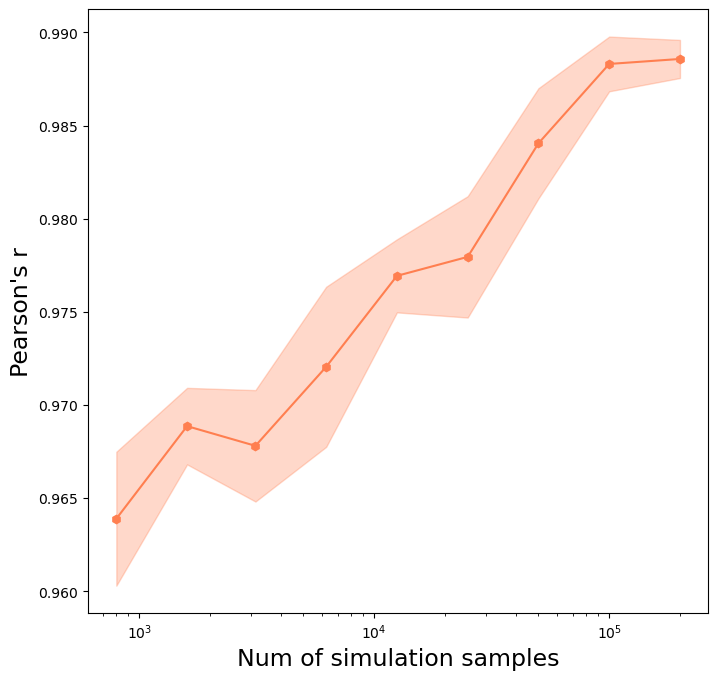

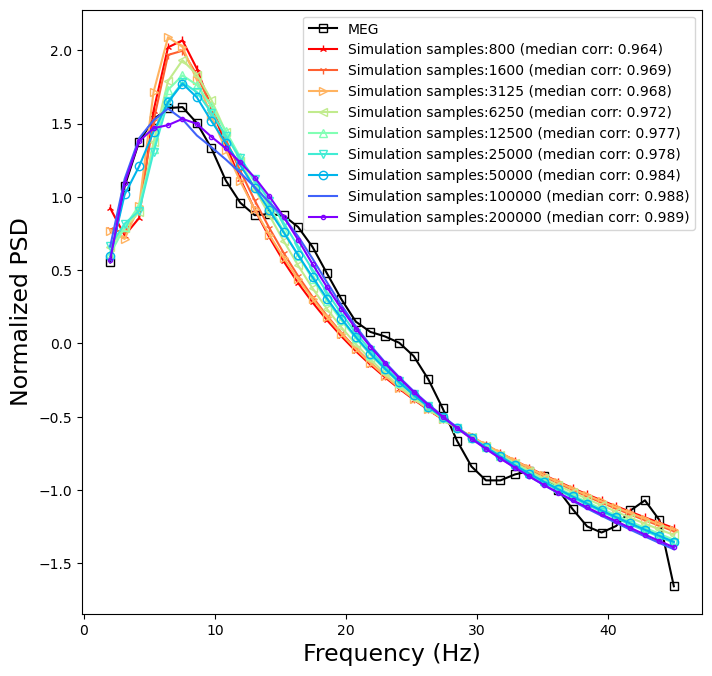

In [97]:
from matplotlib.lines import Line2D
from matplotlib.pyplot import cm
all_markers = list(Line2D.markers.keys())
all_cols = cm.rainbow(np.linspace(0, 1, len(paras.tuningParas.num_prior_spss)))

median_idxs = [np.argmin(np.abs(corrs - np.median(corrs))) for corrs in corrss]
corrs_mean = np.array([np.mean(corrs) for corrs in corrss])
corrs_se = np.array([np.std(corrs)/np.sqrt(10) for corrs in corrss])
lows = corrs_mean - 1.96*corrs_se
ups = corrs_mean + 1.96*corrs_se

plt.figure(figsize=[8, 8], dpi=100)
plt.plot(paras.tuningParas.num_prior_spss, corrs_mean, "-", 
         marker=plot_sets.marker[1], color=plot_sets.col[1])
plt.fill_between(paras.tuningParas.num_prior_spss, lows, ups, color=plot_sets.col[1], alpha=0.3)
plt.xscale("log")
plt.xlabel("Num of simulation samples", fontsize=17)
_ = plt.ylabel("Pearson's r", fontsize=17)
plt.savefig(paras.fig_dir/"tuningSps_overall_PSDcorr.jpg")

plt.figure(figsize=[8, 8], dpi=100)
plt.plot(freqs, std_vec(MEGPSDMean), linestyle = '-',marker = 's',
         fillstyle = 'none',color = 'k', label = "MEG")
for ix in range(len(paras.tuningParas.num_prior_spss)-1, -1, -1):
    label=f"Simulation samples:{paras.tuningParas.num_prior_spss[ix]} (median corr: {corrs_mean[ix]:.3f})"
    plt.plot(freqs, std_vec(np.mean(PSDss[ix], axis=0)), linestyle = '-',marker=all_markers[ix] ,
             fillstyle = 'none',color=all_cols[ix], label=label)
    plt.xlabel('Frequency (Hz)', fontsize = 17)
    plt.legend()
    plt.ylabel('Normalized PSD', fontsize = 17)
plt.savefig(paras.fig_dir/"tuningSps_overall_PSDs.jpg")

#### Corrs for PSD and spatial features for each subject

In [33]:
MEG_psd_each_ROIs = np.array([std_psd(mag2db(ind_psd[:, :, ix])) for ix in range(36)])

PSD_corrss = []
for cur_num_prior_sps in tqdm(paras.tuningParas.num_prior_spss):
    cur_fils = list(paras.tuningParas.path.glob(f"tuningParasSps_{cur_num_prior_sps:.0f}_*"))
    cur_sorted_fils = sorted(cur_fils, key=lambda x: int(x.stem.split("_")[-1]))
    
    PSDCorrs = []
    for ix in range(len(cur_sorted_fils)):
        with open(cur_sorted_fils[ix], "rb") as f:
            curRes = pickle.load(f)
        curSGM_psd_ROIs = np.array(curRes.sgmPSDs)
        for iy in range(MEG_psd_each_ROIs.shape[0]):
            curMEG = MEG_psd_each_ROIs[iy]
            curSGM = curSGM_psd_ROIs[iy]
            PSDCorrs.append(np.mean([scipy.stats.pearsonr(curMEG[iz], curSGM[iz])[0] for iz in range(68)]))
    PSD_corrss.append(PSDCorrs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.05it/s]


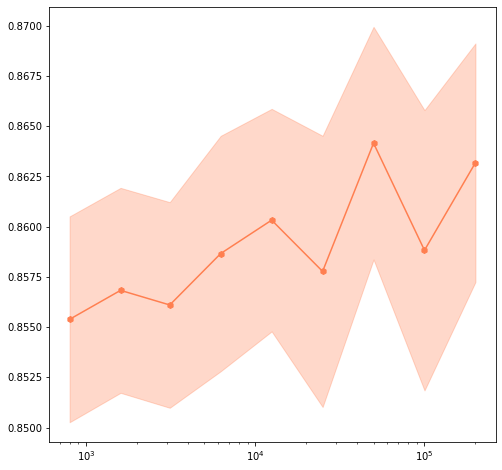

In [51]:
corr_psd_ind_median = np.array([np.median(ix) for ix in PSD_corrss])
corr_psd_ind_mean = np.array([np.mean(ix) for ix in PSD_corrss])
corr_psd_ind_se = np.array([np.std(ix)/np.sqrt(360) for ix in PSD_corrss])
lows = corr_psd_ind_mean - 1.96*corr_psd_ind_se
ups = corr_psd_ind_mean + 1.96*corr_psd_ind_se

plt.figure(figsize=[8, 8])
#plt.title("The corrs for spectral")
plt.plot(paras.tuningParas.num_prior_spss, corr_psd_ind_mean, "-", 
         marker=plot_sets.marker[1], color=plot_sets.col[1])
plt.fill_between(paras.tuningParas.num_prior_spss, lows, ups, color=plot_sets.col[1], alpha=0.3)
plt.xscale("log")

In [55]:
SP_corrss = []

for cur_num_prior_sps in tqdm(paras.tuningParas.num_prior_spss):
    cur_fils = list(paras.tuningParas.path.glob(f"tuningParasSps_{cur_num_prior_sps:.0f}_*"))
    cur_sorted_fils = sorted(cur_fils, key=lambda x: int(x.stem.split("_")[-1]))
    SPCorrs = []
    for ix in range(len(cur_sorted_fils)):
        with open(cur_sorted_fils[ix], "rb") as f:
            curRes = pickle.load(f)
        for mv, ov in zip(curRes.sgmSPs, MEGSPs):
            SPCorrs.append(np.dot(mv/np.linalg.norm(mv), ov))
    SP_corrss.append(np.array(SPCorrs))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.69it/s]


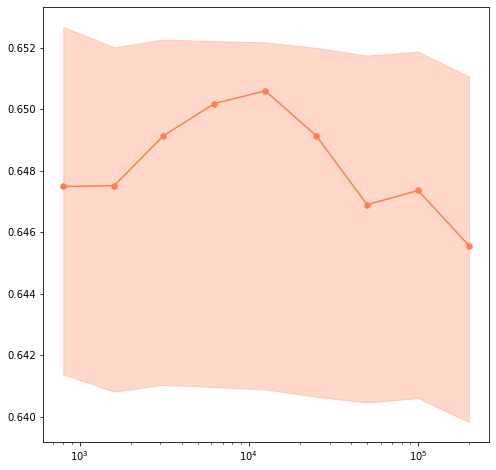

In [57]:
corr_sp_ind_median = np.array([np.median(ix) for ix in SP_corrss])
corr_sp_ind_mean = np.array([np.mean(ix) for ix in SP_corrss])
corr_sp_ind_se = np.array([np.std(ix)/np.sqrt(360) for ix in SP_corrss])
lows = corr_sp_ind_mean - 1.96*corr_sp_ind_se
ups = corr_sp_ind_mean + 1.96*corr_sp_ind_se

plt.figure(figsize=[8, 8])
#plt.title("The corrs for spectral")
plt.plot(paras.tuningParas.num_prior_spss, corr_sp_ind_median, "-", 
         marker=plot_sets.marker[1], color=plot_sets.col[1])
plt.fill_between(paras.tuningParas.num_prior_spss, lows, ups, color=plot_sets.col[1], alpha=0.3)
plt.xscale("log")

In [59]:
len(SP_corrss[0])

360

### Tuning parameters-the noise sd

#### the results saved

In [98]:
fils = list(paras.tuningParas.path.glob("tuningParasSd_*.pkl"))
def tmp_sort(p): 
    sd, idx = p.stem.split("sd")[-1].split("_")
    sd, idx = int(sd), int(idx)
    value = sd - idx
    return -value
sorted_fils = sorted(fils, key=tmp_sort)
paras.tuningParas.noise_sds = [1.6, 0.8, 0.4, 0.3, 0.2]

In [99]:
def tmp_fn1(p): 
    sd, idx = p.stem.split("sd")[-1].split("_")
    sd, idx = int(sd), int(idx)
    return sd, idx

#### Get the posterior samples

In [33]:
for ixfil in tqdm(sorted_fils[:]):
    print(ixfil)
    with open(ixfil, "rb") as f:
        curRes = pickle.load(f)
        
    cur_sd, cur_idx = tmp_fn1(ixfil)
    if not ((cur_sd == 40) and (cur_idx in [4, 5, 6, 7, 8, 9, 10])):
        continue
    print(cur_sd, cur_idx)
    postSpss = []
    for iy in range(ind_psd.shape[-1]):
        curC = ind_conn[:, :, iy]
        curBrain = Brain.Brain()
        curBrain.add_connectome(data_dir) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
        curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
        curBrain.connectome = curC# re-assign connectome to individual connectome
        curBrain.bi_symmetric_c()
        curBrain.reduce_extreme_dir()
        
        sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, iy], freqs, band="alpha")
        stdSp = std_vec(raw_sps.mean(axis=1))
        stdPsd = std_psd(mag2db(ind_psd[:, :, iy])).flatten()
        curX = torch.Tensor(np.concatenate([stdPsd, stdSp]))
        postSps = curRes.posterior.sample((10000, ), x=curX, max_sampling_batch_size=100000)
        postSpss.append(postSps)
        
    
    curRes.postSpss = postSpss
    with open(ixfil, "wb") as f:
        pickle.dump(curRes, f)

  8%|██████████████                                                                                                                                                                  | 4/50 [00:00<00:01, 35.85it/s]

main_results_nsf/tuning_results/tuningParasSd_100000_sd160_1.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd160_2.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd160_3.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd160_4.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd160_5.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd160_6.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd160_7.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd160_8.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd160_9.pkl


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 15/50 [00:00<00:00, 47.70it/s]

main_results_nsf/tuning_results/tuningParasSd_100000_sd160_10.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd80_1.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd80_2.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd80_3.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd80_4.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd80_5.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd80_6.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd80_7.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd80_8.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd80_9.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd80_10.pkl


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 20/50 [00:00<00:00, 48.36it/s]

main_results_nsf/tuning_results/tuningParasSd_100000_sd40_1.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd40_2.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd40_3.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd40_4.pkl
40 4


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

main_results_nsf/tuning_results/tuningParasSd_100000_sd40_5.pkl
40 5


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 20/50 [00:14<00:00, 48.36it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 25/50 [00:23<00:41,  1.67s/it]

main_results_nsf/tuning_results/tuningParasSd_100000_sd40_6.pkl
40 6


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 26/50 [00:36<01:04,  2.69s/it]

main_results_nsf/tuning_results/tuningParasSd_100000_sd40_7.pkl
40 7


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 27/50 [00:50<01:30,  3.94s/it]

main_results_nsf/tuning_results/tuningParasSd_100000_sd40_8.pkl
40 8


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 28/50 [01:02<01:52,  5.10s/it]

main_results_nsf/tuning_results/tuningParasSd_100000_sd40_9.pkl
40 9


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 29/50 [01:14<02:11,  6.26s/it]

main_results_nsf/tuning_results/tuningParasSd_100000_sd40_10.pkl
40 10


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 34/50 [01:25<00:54,  3.41s/it]

main_results_nsf/tuning_results/tuningParasSd_100000_sd30_1.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd30_2.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd30_3.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd30_4.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd30_5.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd30_6.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd30_7.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd30_8.pkl


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [01:25<00:06,  1.08s/it]

main_results_nsf/tuning_results/tuningParasSd_100000_sd30_9.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd30_10.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd20_1.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd20_2.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd20_3.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd20_4.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd20_5.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd20_6.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd20_7.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:25<00:00,  1.72s/it]

main_results_nsf/tuning_results/tuningParasSd_100000_sd20_8.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd20_9.pkl
main_results_nsf/tuning_results/tuningParasSd_100000_sd20_10.pkl


#### Spectral and spatial features estimation

In [100]:
# the estimated spatial feature from MEG
MEGSPs = []
MEGSPRaws = []
for ix in trange(36):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    
    curMEGSP, curMEGSPRaw = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], freqs)
    MEGSPs.append(curMEGSP)
    MEGSPRaws.append(curMEGSPRaw.sum(axis=1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 52.88it/s]


In [ ]:
# the estimated PSD and spatial feature from SGM 
# for each iteration, we have 20 in total 
#cur_noise_sd = paras.tuningParas.noise_sds[0]
for cur_noise_sd in tqdm(paras.tuningParas.noise_sds):
    cur_fils = list(paras.tuningParas.path.glob(f"tuningParasSd_100000_sd{cur_noise_sd*100:.0f}_*"))
    cur_sorted_fils = sorted(cur_fils, key=lambda x: int(x.stem.split("_")[-1]))
    for ixfil in tqdm(cur_sorted_fils[:]):
        sgmPSDs = []
        sgmSPs = []
        with open(ixfil, "rb") as f:
            curRes = pickle.load(f)
            
        curEstParas = np.array([np.median(i.numpy(), axis=0) for i in curRes.postSpss])
        for ix in trange(36):
            curParas = curEstParas[ix, :]
            curC = ind_conn[:, :, ix]
            curBrain = Brain.Brain()
            curBrain.add_connectome(data_dir) # grabs distance matrix
            # re-ordering for DK atlas and normalizing the connectomes:
            curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
            curBrain.connectome = curC# re-assign connectome to individual connectome
            curBrain.bi_symmetric_c()
            curBrain.reduce_extreme_dir()
            
            curSgmModel = Sgm(curBrain.reducedConnectome, curBrain.distance_matrix, freqs)
            curPSD, curSPs = curSgmModel.run_local_coupling_forward(curParas)
            curPSD = curPSD[:68, :]
            curPSD = std_psd(mag2db(np.abs(curPSD)))
            
            sgmPSDs.append(curPSD)
            sgmSPs.append(curSPs.sum(axis=1))
        
        
        
        curRes.sgmPSDs = sgmPSDs
        curRes.sgmSPs = sgmSPs
        with open(ixfil, "wb") as f:
            pickle.dump(curRes, f)

In [101]:
MEGPSDMean = np.mean([std_psd(mag2db(ind_psd[:, :, ix])).mean(axis=0) for ix in range(36)], axis=0)

corrss = []
PSDss = []
for cur_noise_sd in tqdm(paras.tuningParas.noise_sds):
    cur_fils = list(paras.tuningParas.path.glob(f"tuningParasSd_100000_sd{cur_noise_sd*100:.0f}_*"))
    cur_sorted_fils = sorted(cur_fils, key=lambda x: int(x.stem.split("_")[-1]))
    corrs = []
    PSDs = []
    for ix in range(len(cur_sorted_fils)):
        with open(cur_sorted_fils[ix], "rb") as f:
            curRes = pickle.load(f)
        curPSD = np.mean(np.array(curRes.sgmPSDs).mean(axis=1), axis=0)
        cor = scipy.stats.pearsonr(std_vec(MEGPSDMean), std_vec(curPSD))[0]
        corrs.append(cor)
        PSDs.append(curPSD)
    
    corrss.append(corrs)
    PSDss.append(PSDs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.65s/it]


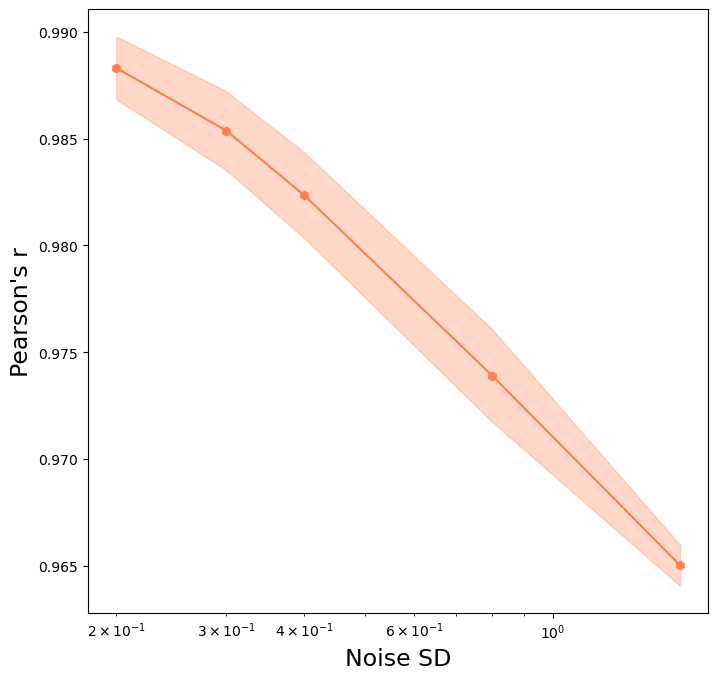

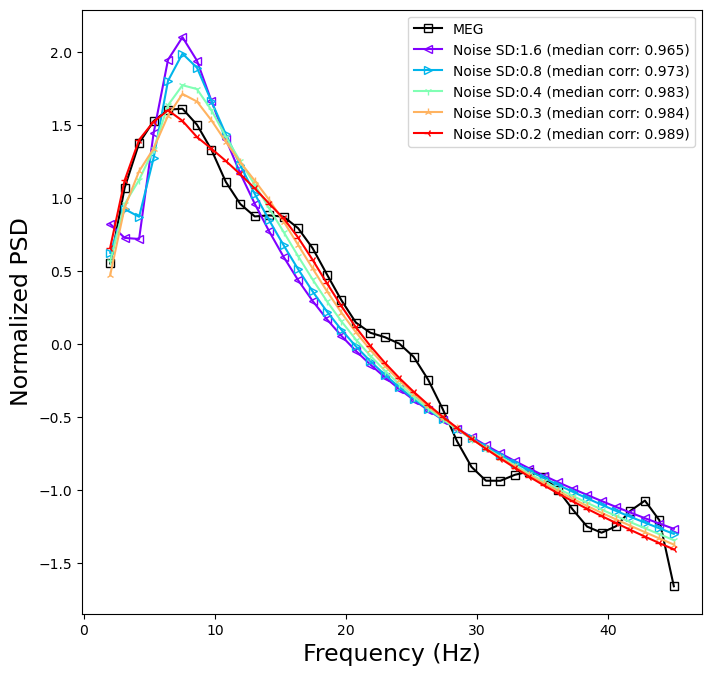

In [79]:
from matplotlib.lines import Line2D
from matplotlib.pyplot import cm
all_markers = list(Line2D.markers.keys())[5:]
all_cols = cm.rainbow(np.linspace(0, 1, 5))

median_idxs = [np.argmin(np.abs(corrs - np.median(corrs))) for corrs in corrss]
corrs_mean = np.array([np.mean(corrs) for corrs in corrss])
corrs_se = np.array([np.std(corrs)/np.sqrt(10) for corrs in corrss])
lows = corrs_mean - 1.96*corrs_se
ups = corrs_mean + 1.96*corrs_se


plt.figure(figsize=[8, 8], dpi=100)
plt.plot(paras.tuningParas.noise_sds, corrs_mean, "-", 
         marker=plot_sets.marker[1], color=plot_sets.col[1])
plt.fill_between(paras.tuningParas.noise_sds, lows, ups, color=plot_sets.col[1], alpha=0.3)
plt.xscale("log")
plt.xlabel("Noise SD", fontsize=17)
_ = plt.ylabel("Pearson's r", fontsize=17)
plt.savefig(paras.fig_dir/"tuningSD_overall_PSDcorr.jpg")

plt.figure(figsize=[8, 8], dpi=100)
plt.plot(freqs, std_vec(MEGPSDMean), linestyle = '-',marker = 's',
         fillstyle = 'none',color = 'k', label = "MEG")
for ix in range(len(paras.tuningParas.noise_sds)):
    label=f"Noise SD:{paras.tuningParas.noise_sds[ix]} (median corr: {np.median(corrss[ix]):.3f})"
    plt.plot(freqs, std_vec(np.mean(PSDss[ix], axis=0)), linestyle = '-',marker=all_markers[ix] ,
             fillstyle = 'none',color=all_cols[ix], label=label)
    plt.xlabel('Frequency (Hz)', fontsize = 17)
    plt.legend()
    plt.ylabel('Normalized PSD', fontsize = 17)
plt.savefig(paras.fig_dir/"tuningSD_overall_PSDs.jpg")

#### Corrs for PSD and spatial features for each subject

In [39]:
MEG_psd_each_ROIs = np.array([std_psd(mag2db(ind_psd[:, :, ix])) for ix in range(36)])
PSD_corrss = []

for cur_noise_sd in tqdm(paras.tuningParas.noise_sds):
    cur_fils = list(paras.tuningParas.path.glob(f"tuningParasSd_100000_sd{cur_noise_sd*100:.0f}_*"))
    cur_sorted_fils = sorted(cur_fils, key=lambda x: int(x.stem.split("_")[-1]))
    PSDCorrs = []
    for ix in range(len(cur_sorted_fils[:])):
        with open(cur_sorted_fils[ix], "rb") as f:
            curRes = pickle.load(f)
        curSGM_psd_ROIs = np.array(curRes.sgmPSDs)
        for iy in range(MEG_psd_each_ROIs.shape[0]):
            curMEG = MEG_psd_each_ROIs[iy]
            curSGM = curSGM_psd_ROIs[iy]
            PSDCorrs.append(np.mean([scipy.stats.pearsonr(curMEG[iz], curSGM[iz])[0] for iz in range(68)]))
    PSD_corrss.append(PSDCorrs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


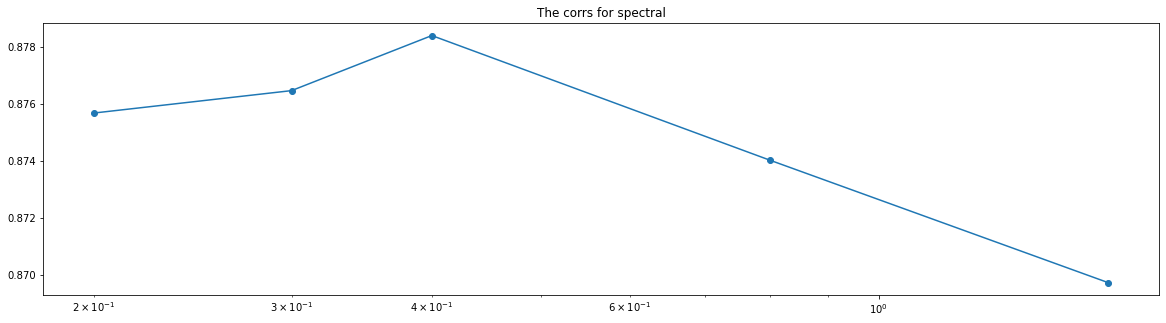

In [49]:
plt.figure(figsize=[20, 5])
plt.title("The corrs for spectral")
_ = plt.plot(paras.tuningParas.noise_sds, [np.median(ix) for ix in PSD_corrss], "o-")
plt.xscale("log")

In [45]:
SP_corrss = []

for cur_noise_sd in tqdm(paras.tuningParas.noise_sds):
    cur_fils = list(paras.tuningParas.path.glob(f"tuningParasSd_100000_sd{cur_noise_sd*100:.0f}_*"))
    cur_sorted_fils = sorted(cur_fils, key=lambda x: int(x.stem.split("_")[-1]))
    SPCorrs = []
    for ix in range(len(cur_sorted_fils)):
        with open(cur_sorted_fils[ix], "rb") as f:
            curRes = pickle.load(f)
        for mv, ov in zip(curRes.sgmSPs, MEGSPs):
            SPCorrs.append(np.dot(mv/np.linalg.norm(mv), ov))
    SP_corrss.append(np.array(SPCorrs))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


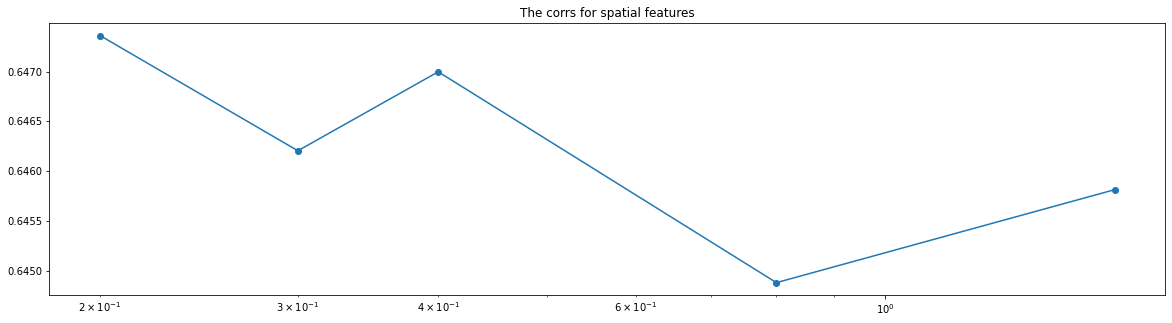

In [46]:
plt.figure(figsize=[20, 5])
plt.title("The corrs for spatial features")
_ = plt.plot(paras.tuningParas.noise_sds, [np.median(ix) for ix in SP_corrss], "o-")
plt.xscale("log")